In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras import backend as K
from keras.callbacks import EarlyStopping
K.tensorflow_backend._get_available_gpus()
from matplotlib.pyplot import imshow
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import cv2
import os
from keras.utils import np_utils
from tqdm import tqdm, trange


Using TensorFlow backend.


In [2]:
train_folder_path = "real_train"
validate_folder_path = "real_val"

alphabet = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
alphabet_to_num = dict()
num = 0
for al in alphabet:
    alphabet_to_num[al] = num
    num += 1

In [3]:
def preprocessing(path):
    datas = os.listdir(path)
#     processed_data = np.stack([img_to_array(load_img(path + '/' + data).resize((137,51)))/255.0 for data in tqdm(datas)])
    processed_data = np.stack([img_to_array(load_img(path + '/' + data).resize((137,51)))/255.0 for data in tqdm(datas)])
    return processed_data

In [4]:
def get_label(path):
    label_data = [[], [], [], []]
    datas = os.listdir(path)
    for data in tqdm(datas):
        label = data.split('.')[0]
        for i in range(len(label)):
            label_data[i].append(np_utils.to_categorical(alphabet_to_num[label[i]], num_classes=36))

    for i in range(len(label_data)):
        label_data[i] = np.array(label_data[i])
    return label_data

In [5]:
train_datas = os.listdir(train_folder_path)
val_datas = os.listdir(validate_folder_path)
print(len(train_datas))
print(len(val_datas))

2001
300


In [13]:
def data_generator(path):
    # Generators for keras must be infinite
    datas = os.listdir(path)
    iterator = iter(datas)
    while True:
        data = next(iterator, None)
        if not data:
            iterator = iter(datas)
            data = next(iterator, None)
        processed_data = img_to_array(load_img(path + '/' + data).resize((137,51)))/255.0
        label = data.split('.')[0]
        # Need array shape for (1,36) here
        labels = [np.asarray([np_utils.to_categorical(alphabet_to_num[char], num_classes=36)]) for char in label.split('_')[0]]
        yield np.asarray([processed_data]), labels
    

In [14]:
from PIL import Image
from PIL.ImageDraw import Draw
from PIL.ImageFont import truetype
from PIL import ImageOps
import matplotlib.pyplot as plt
import numpy as np
import random
from captcha.image import ImageCaptcha
import string
def cust_create_captcha_image(chars, color, background, wd, he):
        """Create the CAPTCHA image itself.
        :param chars: text to be generated.
        :param color: color of the text.
        :param background: color of the background.
        The color should be a tuple of 3 numbers, such as (0, 255, 255).
        """ 
        generator = ImageCaptcha(width=wd, height=he, fonts=['font/BEBAS.ttf'])
        
        image = Image.new('RGB', (wd, he), background)
        draw = Draw(image)

        
        table  =  []
        for  i  in  range( 256 ):
            table.append( i * 1.97 )
        
        def _draw_character(c):
            font = truetype('font/BEBAS.ttf', 36)
            w, h = draw.textsize(c, font=font)

            dx = random.randint(0, 4)
            dy = random.randint(0, 6)
            im = Image.new('RGB', (w + dx, h + dy))
            Draw(im).text((dx, dy), c, font=font, fill=color)

#             rotate
            im = im.crop(im.getbbox())
            im = im.rotate(random.uniform(-15, 15), Image.BILINEAR, expand=1)
            return im

        images = []
        for c in chars:
            if random.random() > 0.5:
                images.append(_draw_character(" "))
            images.append(_draw_character(c))
            

        text_width = sum([im.size[0] for im in images])

        width = max(text_width, wd)
        image = image.resize((width, he))

        average = int(text_width / len(chars))
        rand = int(0.25 * average)
#         offset = int(average * 0.1)
#         print(offset)
        offset = rand
       
    
        for im in images:
            w, h = im.size
            word_h = random.randint(0, int(he - h))
            mask = im.convert('L').point(table)
#             image.paste(ImageOps.colorize(mask, (0,0,0), (0,0,0)), (offset, int((he - h) / 2)), mask)
            image.paste(ImageOps.colorize(mask, (0,0,0), (0,0,0)), (offset, word_h), mask)
            offset = offset + w + random.randint(-rand, 0)

        if width > wd:
            image = image.resize((wd, he))

        def create_noise_curve(image, color):
            w, h = image.size
            points = [-20, 8,140, 40]
            start = 180
            end = -30
            Draw(image).arc(points, start, end, fill=color, width=5)
            return image
            
            
        word_img = image
        curve_image = Image.new('RGB', (wd, he), "white")
        image_curve = create_noise_curve(curve_image, "black")
        pix_curve = np.array(image_curve)
        pix_word = np.array(word_img)
        
        result = pix_word ^ pix_curve
        result = ~result 
        result = result & 211
        img = Image.fromarray(np.uint8(result))
        
        generator.create_noise_dots(img, (0,0,0), width=1, number=50)
        generator.create_noise_dots(img, (230,230,230), width=1, number=800)
        
        
        return img

ImportError: No module named 'captcha'

In [15]:
from captcha.image import ImageCaptcha
import random
import string

characters = string.digits + string.ascii_uppercase
# width, height, n_len, n_class = 170, 80, 4, len(characters)
# generator = ImageCaptcha(width=width, height=height)

def data_gen_dynamic(batch_size):
#     k = True
    while True:
        x = []
        y = [[],[],[],[]]
        for _ in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            img = cust_create_captcha_image(random_str, "white", "white", 137, 51)
            x.append(img_to_array(img)/255.0)
            for i in range(len(random_str)):
                y[i].append(np_utils.to_categorical(alphabet_to_num[random_str[i]], num_classes=36))
            
            for l in y:
                l = np.array(l)
                
#             y.append([np.asarray([np_utils.to_categorical(alphabet_to_num[char], num_classes=36)]) for char in random_str])
#         k = False
        yield np.asarray(x), y
     

ImportError: No module named 'captcha'

In [16]:
for item in data_gen_dynamic(2):
    print(item.shape)

NameError: name 'data_gen_dynamic' is not defined

In [17]:
# CNN_Model
input_layer = Input((51, 137, 3))
out = input_layer
out = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(out)
out = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(out)
out = BatchNormalization()(out)
out = MaxPooling2D(pool_size=(2, 2))(out)
out = Dropout(0.3)(out)
out = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(out)
out = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(out)
out = BatchNormalization()(out)
out = MaxPooling2D(pool_size=(2, 2))(out)
out = Dropout(0.3)(out)
out = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(out)
out = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(out)
out = BatchNormalization()(out)
out = MaxPooling2D(pool_size=(2, 2))(out)
out = Dropout(0.3)(out)
out = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(out)
out = BatchNormalization()(out)
out = MaxPooling2D(pool_size=(2, 2))(out)
out = Flatten()(out)
out = Dropout(0.3)(out)
out = [Dense(36, name='digit1', activation='softmax')(out),\
    Dense(36, name='digit2', activation='softmax')(out),\
    Dense(36, name='digit3', activation='softmax')(out),\
    Dense(36, name='digit4', activation='softmax')(out)]
my_model = Model(inputs=input_layer, outputs=out)
losses = {
    "digit1": "categorical_crossentropy",
    "digit2": "categorical_crossentropy",
    "digit3": "categorical_crossentropy",
    "digit4": "categorical_crossentropy"
}
my_model.compile(loss=losses, optimizer="adamax", metrics=['accuracy'])
my_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 51, 137, 3)   0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 51, 137, 32)  896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 49, 135, 32)  9248        conv2d_8[0][0]                   
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 49, 135, 32)  128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [18]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50)


In [19]:
history = my_model.fit_generator(data_generator("real_train"), samples_per_epoch=len(train_datas), epochs=300, validation_data=data_generator(validate_folder_path), validation_steps=len(val_datas), callbacks=[early_stopping])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., epochs=300, steps_per_epoch=2001, callbacks=[<keras.ca..., validation_steps=300)`
  """Entry point for launching an IPython kernel.


Epoch 1/300
2001/2001 [==============================] - 20s 10ms/step - loss: 11.2289 - digit1_loss: 2.5497 - digit2_loss: 2.8538 - digit3_loss: 2.8167 - digit4_loss: 3.0088 - digit1_acc: 0.3108 - digit2_acc: 0.2454 - digit3_acc: 0.2384 - digit4_acc: 0.1919 - val_loss: 8.7716 - val_digit1_loss: 2.5089 - val_digit2_loss: 1.7739 - val_digit3_loss: 1.8688 - val_digit4_loss: 2.6201 - val_digit1_acc: 0.4433 - val_digit2_acc: 0.4667 - val_digit3_acc: 0.4333 - val_digit4_acc: 0.2933
Epoch 2/300
2001/2001 [==============================] - 21s 10ms/step - loss: 5.0048 - digit1_loss: 1.0603 - digit2_loss: 1.2679 - digit3_loss: 1.2411 - digit4_loss: 1.4355 - digit1_acc: 0.6622 - digit2_acc: 0.6027 - digit3_acc: 0.5987 - digit4_acc: 0.5532 - val_loss: 4.3900 - val_digit1_loss: 1.1006 - val_digit2_loss: 0.8707 - val_digit3_loss: 0.8291 - val_digit4_loss: 1.5896 - val_digit1_acc: 0.6867 - val_digit2_acc: 0.7167 - val_digit3_acc: 0.7333 - val_digit4_acc: 0.5500
Epoch 3/300
2001/2001 [==============

2001/2001 [==============================] - 21s 10ms/step - loss: 0.0367 - digit1_loss: 0.0055 - digit2_loss: 0.0118 - digit3_loss: 0.0073 - digit4_loss: 0.0120 - digit1_acc: 0.9995 - digit2_acc: 0.9970 - digit3_acc: 0.9990 - digit4_acc: 0.9965 - val_loss: 0.8263 - val_digit1_loss: 0.2132 - val_digit2_loss: 0.1578 - val_digit3_loss: 0.1157 - val_digit4_loss: 0.3396 - val_digit1_acc: 0.9167 - val_digit2_acc: 0.9667 - val_digit3_acc: 0.9633 - val_digit4_acc: 0.9100
Epoch 19/300
2001/2001 [==============================] - 20s 10ms/step - loss: 0.0354 - digit1_loss: 0.0088 - digit2_loss: 0.0108 - digit3_loss: 0.0082 - digit4_loss: 0.0077 - digit1_acc: 0.9975 - digit2_acc: 0.9965 - digit3_acc: 0.9965 - digit4_acc: 0.9980 - val_loss: 1.0274 - val_digit1_loss: 0.3833 - val_digit2_loss: 0.1476 - val_digit3_loss: 0.1340 - val_digit4_loss: 0.3625 - val_digit1_acc: 0.8833 - val_digit2_acc: 0.9733 - val_digit3_acc: 0.9667 - val_digit4_acc: 0.9000
Epoch 20/300
2001/2001 [=========================

2001/2001 [==============================] - 21s 10ms/step - loss: 0.0085 - digit1_loss: 0.0016 - digit2_loss: 0.0025 - digit3_loss: 0.0028 - digit4_loss: 0.0015 - digit1_acc: 0.9995 - digit2_acc: 0.9990 - digit3_acc: 0.9985 - digit4_acc: 1.0000 - val_loss: 0.8670 - val_digit1_loss: 0.2544 - val_digit2_loss: 0.1143 - val_digit3_loss: 0.1235 - val_digit4_loss: 0.3748 - val_digit1_acc: 0.9233 - val_digit2_acc: 0.9767 - val_digit3_acc: 0.9833 - val_digit4_acc: 0.9100
Epoch 36/300
2001/2001 [==============================] - 21s 10ms/step - loss: 0.0087 - digit1_loss: 0.0018 - digit2_loss: 0.0027 - digit3_loss: 0.0018 - digit4_loss: 0.0024 - digit1_acc: 1.0000 - digit2_acc: 0.9995 - digit3_acc: 0.9995 - digit4_acc: 0.9995 - val_loss: 0.9342 - val_digit1_loss: 0.3228 - val_digit2_loss: 0.1405 - val_digit3_loss: 0.1477 - val_digit4_loss: 0.3233 - val_digit1_acc: 0.9267 - val_digit2_acc: 0.9667 - val_digit3_acc: 0.9800 - val_digit4_acc: 0.9267
Epoch 37/300
2001/2001 [=========================

Epoch 52/300
2001/2001 [==============================] - 21s 10ms/step - loss: 0.0096 - digit1_loss: 0.0030 - digit2_loss: 0.0031 - digit3_loss: 0.0022 - digit4_loss: 0.0013 - digit1_acc: 0.9990 - digit2_acc: 0.9995 - digit3_acc: 0.9990 - digit4_acc: 0.9995 - val_loss: 0.7273 - val_digit1_loss: 0.2043 - val_digit2_loss: 0.0919 - val_digit3_loss: 0.1337 - val_digit4_loss: 0.2974 - val_digit1_acc: 0.9467 - val_digit2_acc: 0.9833 - val_digit3_acc: 0.9800 - val_digit4_acc: 0.9333
Epoch 53/300
2001/2001 [==============================] - 21s 10ms/step - loss: 0.0048 - digit1_loss: 0.0016 - digit2_loss: 0.0017 - digit3_loss: 9.4525e-04 - digit4_loss: 4.5620e-04 - digit1_acc: 0.9995 - digit2_acc: 0.9995 - digit3_acc: 0.9995 - digit4_acc: 1.0000 - val_loss: 0.7629 - val_digit1_loss: 0.2853 - val_digit2_loss: 0.0833 - val_digit3_loss: 0.0792 - val_digit4_loss: 0.3151 - val_digit1_acc: 0.9267 - val_digit2_acc: 0.9800 - val_digit3_acc: 0.9833 - val_digit4_acc: 0.9233
Epoch 54/300
2001/2001 [====

Epoch 69/300
2001/2001 [==============================] - 21s 10ms/step - loss: 0.0021 - digit1_loss: 6.3021e-04 - digit2_loss: 7.5659e-04 - digit3_loss: 5.8697e-04 - digit4_loss: 1.4358e-04 - digit1_acc: 1.0000 - digit2_acc: 0.9995 - digit3_acc: 1.0000 - digit4_acc: 1.0000 - val_loss: 0.7335 - val_digit1_loss: 0.2467 - val_digit2_loss: 0.0822 - val_digit3_loss: 0.1438 - val_digit4_loss: 0.2608 - val_digit1_acc: 0.9367 - val_digit2_acc: 0.9800 - val_digit3_acc: 0.9800 - val_digit4_acc: 0.9433
Epoch 70/300
2001/2001 [==============================] - 21s 10ms/step - loss: 9.6322e-04 - digit1_loss: 2.9091e-04 - digit2_loss: 3.7827e-04 - digit3_loss: 1.9111e-04 - digit4_loss: 1.0292e-04 - digit1_acc: 1.0000 - digit2_acc: 1.0000 - digit3_acc: 1.0000 - digit4_acc: 1.0000 - val_loss: 0.7375 - val_digit1_loss: 0.2568 - val_digit2_loss: 0.0952 - val_digit3_loss: 0.1348 - val_digit4_loss: 0.2507 - val_digit1_acc: 0.9333 - val_digit2_acc: 0.9767 - val_digit3_acc: 0.9800 - val_digit4_acc: 0.9367


2001/2001 [==============================] - 21s 11ms/step - loss: 0.0014 - digit1_loss: 0.0011 - digit2_loss: 1.3461e-04 - digit3_loss: 3.4308e-05 - digit4_loss: 2.0152e-04 - digit1_acc: 0.9995 - digit2_acc: 1.0000 - digit3_acc: 1.0000 - digit4_acc: 1.0000 - val_loss: 0.7488 - val_digit1_loss: 0.2552 - val_digit2_loss: 0.1029 - val_digit3_loss: 0.1282 - val_digit4_loss: 0.2625 - val_digit1_acc: 0.9533 - val_digit2_acc: 0.9767 - val_digit3_acc: 0.9767 - val_digit4_acc: 0.9400
Epoch 86/300
2001/2001 [==============================] - 21s 10ms/step - loss: 0.0013 - digit1_loss: 3.4775e-04 - digit2_loss: 1.0028e-04 - digit3_loss: 8.5042e-04 - digit4_loss: 1.8315e-05 - digit1_acc: 1.0000 - digit2_acc: 1.0000 - digit3_acc: 0.9995 - digit4_acc: 1.0000 - val_loss: 0.7233 - val_digit1_loss: 0.2534 - val_digit2_loss: 0.0877 - val_digit3_loss: 0.1028 - val_digit4_loss: 0.2795 - val_digit1_acc: 0.9467 - val_digit2_acc: 0.9767 - val_digit3_acc: 0.9867 - val_digit4_acc: 0.9400
Epoch 87/300
2001/200

2001/2001 [==============================] - 22s 11ms/step - loss: 5.8508e-04 - digit1_loss: 3.4488e-04 - digit2_loss: 2.8234e-05 - digit3_loss: 1.2540e-04 - digit4_loss: 8.6572e-05 - digit1_acc: 1.0000 - digit2_acc: 1.0000 - digit3_acc: 1.0000 - digit4_acc: 1.0000 - val_loss: 0.7713 - val_digit1_loss: 0.2386 - val_digit2_loss: 0.1585 - val_digit3_loss: 0.1119 - val_digit4_loss: 0.2623 - val_digit1_acc: 0.9367 - val_digit2_acc: 0.9667 - val_digit3_acc: 0.9767 - val_digit4_acc: 0.9400
Epoch 102/300
2001/2001 [==============================] - 22s 11ms/step - loss: 9.7307e-04 - digit1_loss: 8.1797e-04 - digit2_loss: 5.4061e-05 - digit3_loss: 7.2873e-05 - digit4_loss: 2.8169e-05 - digit1_acc: 0.9995 - digit2_acc: 1.0000 - digit3_acc: 1.0000 - digit4_acc: 1.0000 - val_loss: 0.8152 - val_digit1_loss: 0.2260 - val_digit2_loss: 0.1437 - val_digit3_loss: 0.1462 - val_digit4_loss: 0.2993 - val_digit1_acc: 0.9400 - val_digit2_acc: 0.9733 - val_digit3_acc: 0.9767 - val_digit4_acc: 0.9367
Epoch 10

2001/2001 [==============================] - 22s 11ms/step - loss: 3.6078e-04 - digit1_loss: 1.3872e-04 - digit2_loss: 5.8874e-05 - digit3_loss: 1.3841e-04 - digit4_loss: 2.4780e-05 - digit1_acc: 1.0000 - digit2_acc: 1.0000 - digit3_acc: 1.0000 - digit4_acc: 1.0000 - val_loss: 0.7622 - val_digit1_loss: 0.2035 - val_digit2_loss: 0.1438 - val_digit3_loss: 0.1307 - val_digit4_loss: 0.2841 - val_digit1_acc: 0.9567 - val_digit2_acc: 0.9733 - val_digit3_acc: 0.9867 - val_digit4_acc: 0.9467
Epoch 118/300
2001/2001 [==============================] - 21s 10ms/step - loss: 0.0013 - digit1_loss: 0.0011 - digit2_loss: 9.2073e-05 - digit3_loss: 7.5258e-05 - digit4_loss: 2.5240e-05 - digit1_acc: 0.9995 - digit2_acc: 1.0000 - digit3_acc: 1.0000 - digit4_acc: 1.0000 - val_loss: 0.7184 - val_digit1_loss: 0.1823 - val_digit2_loss: 0.1358 - val_digit3_loss: 0.1349 - val_digit4_loss: 0.2655 - val_digit1_acc: 0.9567 - val_digit2_acc: 0.9700 - val_digit3_acc: 0.9833 - val_digit4_acc: 0.9533
Epoch 119/300
20

2001/2001 [==============================] - 21s 10ms/step - loss: 1.0327e-04 - digit1_loss: 3.4098e-05 - digit2_loss: 1.4388e-05 - digit3_loss: 8.9705e-06 - digit4_loss: 4.5817e-05 - digit1_acc: 1.0000 - digit2_acc: 1.0000 - digit3_acc: 1.0000 - digit4_acc: 1.0000 - val_loss: 0.7297 - val_digit1_loss: 0.1567 - val_digit2_loss: 0.1861 - val_digit3_loss: 0.1312 - val_digit4_loss: 0.2556 - val_digit1_acc: 0.9733 - val_digit2_acc: 0.9667 - val_digit3_acc: 0.9867 - val_digit4_acc: 0.9500
Epoch 134/300
2001/2001 [==============================] - 21s 10ms/step - loss: 3.6571e-04 - digit1_loss: 2.0442e-04 - digit2_loss: 1.2018e-04 - digit3_loss: 6.1393e-06 - digit4_loss: 3.4966e-05 - digit1_acc: 1.0000 - digit2_acc: 1.0000 - digit3_acc: 1.0000 - digit4_acc: 1.0000 - val_loss: 0.7032 - val_digit1_loss: 0.1519 - val_digit2_loss: 0.1659 - val_digit3_loss: 0.1327 - val_digit4_loss: 0.2527 - val_digit1_acc: 0.9800 - val_digit2_acc: 0.9700 - val_digit3_acc: 0.9833 - val_digit4_acc: 0.9500
Epoch 13

2001/2001 [==============================] - 21s 11ms/step - loss: 8.8021e-04 - digit1_loss: 2.4365e-05 - digit2_loss: 4.0900e-04 - digit3_loss: 2.7333e-04 - digit4_loss: 1.7352e-04 - digit1_acc: 1.0000 - digit2_acc: 0.9995 - digit3_acc: 1.0000 - digit4_acc: 1.0000 - val_loss: 0.6909 - val_digit1_loss: 0.1834 - val_digit2_loss: 0.1265 - val_digit3_loss: 0.1097 - val_digit4_loss: 0.2714 - val_digit1_acc: 0.9667 - val_digit2_acc: 0.9733 - val_digit3_acc: 0.9867 - val_digit4_acc: 0.9433
Epoch 150/300
2001/2001 [==============================] - 21s 11ms/step - loss: 5.0385e-04 - digit1_loss: 1.4941e-05 - digit2_loss: 3.9125e-04 - digit3_loss: 7.1648e-06 - digit4_loss: 9.0488e-05 - digit1_acc: 1.0000 - digit2_acc: 0.9995 - digit3_acc: 1.0000 - digit4_acc: 1.0000 - val_loss: 0.6727 - val_digit1_loss: 0.1631 - val_digit2_loss: 0.1324 - val_digit3_loss: 0.1069 - val_digit4_loss: 0.2703 - val_digit1_acc: 0.9667 - val_digit2_acc: 0.9700 - val_digit3_acc: 0.9900 - val_digit4_acc: 0.9433
Epoch 15

In [37]:
# history = my_model.fit_generator(data_gen_dynamic(128), samples_per_epoch=256, epochs=300, validation_data=data_generator(validate_folder_path), validation_steps=len(val_datas), callbacks=[early_stopping])

In [27]:
# history = my_model.fit_generator(data_generator(train_folder_path), samples_per_epoch=len(train_datas), epochs=100, validation_data=data_generator(validate_folder_path), validation_steps=len(val_datas))

In [28]:
# history = my_model.fit(train_data, train_label, validation_data=(val_data, val_label), batch_size=32, epochs=100, callbacks=[early_stopping])

In [20]:
acc = (np.array(history.history['digit1_acc'])+np.array(history.history['digit2_acc'])+np.array(history.history['digit3_acc'])+np.array(history.history['digit4_acc']))/4
val_acc = (np.array(history.history['val_digit1_acc'])+np.array(history.history['val_digit2_acc'])+np.array(history.history['val_digit3_acc'])+np.array(history.history['val_digit4_acc']))/4

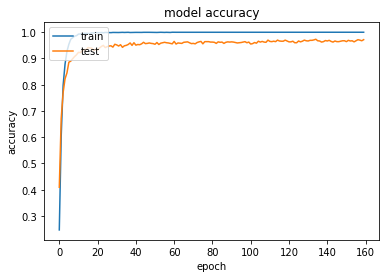

In [21]:
# plt.plot(history.history['digit1_acc'])
# plt.plot(history.history['val_digit1_acc'])
# plt.plot(history.history['digit2_acc'])
# plt.plot(history.history['val_digit2_acc'])
# plt.plot(history.history['digit3_acc'])
# plt.plot(history.history['val_digit3_acc'])
# plt.plot(history.history['digit4_acc'])
# plt.plot(history.history['val_digit4_acc'])
plt.plot(acc)
plt.plot(val_acc)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

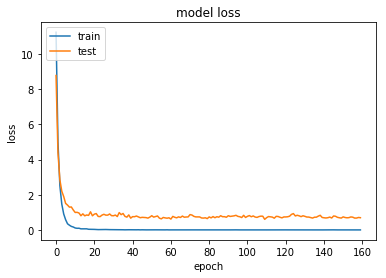

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
my_model.save('my_model_20190201.h5')

In [ ]:
predict_test = my_model.predict(np.asarray([train_data[1]]))
for item in predict_test:
    index = np.argmax(item)
    print(alphabet[index])

In [53]:
test_data_set = preprocessing("test_set")
result =  my_model.predict(test_data_set)
for item in result:
    index = np.argmax(item)
    print(alphabet[index])

100%|██████████| 1/1 [00:00<00:00, 1021.01it/s]

Q
4
P
Y


In [51]:
test_data_set.shape

(1, 51, 137, 3)